# Assignment 5: Statistical Analysis (30 pt)

Use as many Python and markdown cells per question as you deem necessary. **DO NOT SUBMIT CODE THAT DOES NOT RUN.** You will lose points for code that throws errors. 

Questions 1 and 2 will use data describing various wetlands, intertidal zones, and ocean conditions in the United States from 1972-2015. This data has been adapted from [publicly available data from NASA](https://daac.ornl.gov/NACP/guides/Tidal_Wetland_Estuaries_Data.html). Note that this file uses the value `-9999` to denote missing data. This file's path is `data/tidal_wetland_estuaries.csv`.

Question 3 will be using time series data describing the proportion of electricity produced by coal in high income countries from [the World Bank](https://data.worldbank.org/indicator/EG.ELC.COAL.ZS). The path to the file is `data/coal-production.csv`.


## Question 1: t-tests (10 pt)

Using the data from `tidal_wetland_estuaries.csv`, test the hypothesis that soil organic carbon density (column name: `soc_density`) is **larger** in the East coast than the West coast with a t-test. Interpret the t-test. (5 pt)

Defend your choice of which type of t-test you used (3 pt).

Do the data meet the requirement for normal data? Why or why not? (2 pt) 

In [3]:
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('white')

df = pd.read_csv('data/tidal_wetland_estuaries.csv')

df.head()

,name,coast,estu_latitude,estu_longintude,estu_dep,estu_perim,land_area,land_latitude,land_longitude,population,...,ocean_salinity_mean,air_temp_mean,frost_days_per_yr,ocean_sst_mean,ocean_diss_inorg_p,ocean_no3,tide_flow,mean_precip,mean_temp,soc_density
0,Florida Bay,GULF,25.039940,-80.731770,0.62000,614000.000,9.048954e+08,25.187310,-80.727540,3421,...,36.2,24.4,0.0,26.50,0.07,0.810,1.000000e+09,1251.831801,24.594719,0.087
1,South Ten Thousand Islands,GULF,25.311330,-81.057020,0.63000,597000.000,3.069216e+09,25.440250,-80.791070,235792,...,36.1,24.6,0.0,26.40,0.08,0.780,3.000000e+08,1355.907147,24.320596,0.000
2,North Ten Thousand Islands,GULF,25.724280,-81.377640,0.73000,906000.000,4.921106e+09,25.982520,-81.273680,9268,...,36.0,24.1,0.0,26.30,0.09,0.790,6.000000e+08,1416.239789,23.873671,0.084
3,Rookery Bay,GULF,25.998750,-81.756010,0.50000,148000.000,3.304589e+08,26.042920,-81.677710,14858,...,36.0,23.9,0.0,26.10,0.08,0.670,4.000000e+07,1432.519416,23.510000,0.086
4,Charlotte Harbor,GULF,26.754031,-82.103018,1.65938,507261.119,1.169284e+10,27.167615,-81.772154,597644,...,35.9,23.2,1.0,25.65,0.10,0.545,7.000000e+08,1320.275690,22.869199,0.073


In [17]:
df_east = df.loc[(df['coast']=='EAST') & (df['soc_density']!=-9999),:]
df_west = df.loc[(df['coast']=='WEST') & (df['soc_density']!=-9999),:]

stats.ttest_ind(df_east['soc_density'], df_west['soc_density'], alternative="greater")

Ttest_indResult(statistic=8.45031778669312, pvalue=5.765284478012742e-13)

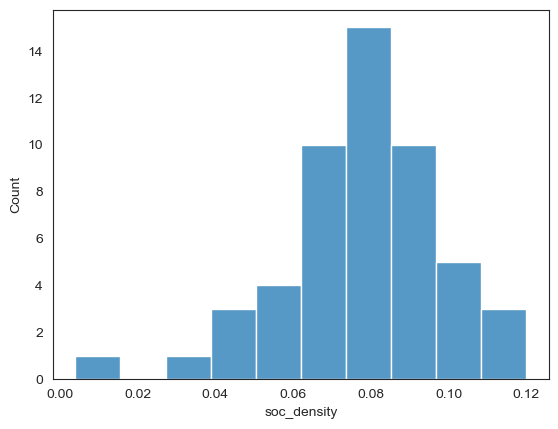

In [26]:
sns.histplot(df_east['soc_density'])
plt.savefig('eastCoastHistPlot.png')

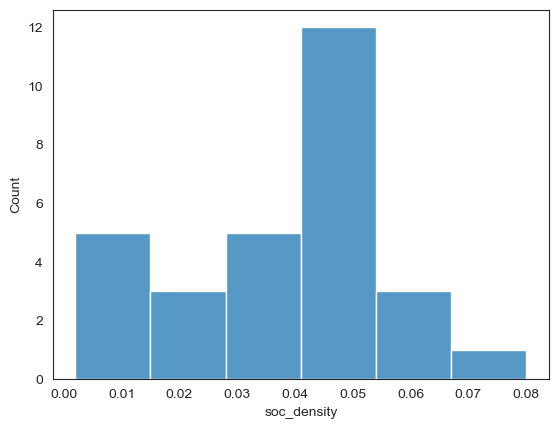

In [27]:
sns.histplot(df_west['soc_density'])
plt.savefig('westCoastHistPlot.png')

Because the p-value calculated is less than .05, we reject the null hypothesis in favor of the alternative hypothesis. The null hypothesis says that there is no significant difference between the soil organic carbon density on the east and west coast (or that the difference is less than 0, which would mean that the soil organic carbon density is greater on the West Coast than the East Coast), and the alternative hypothesis says that soil organic carbon density is greater on the East Coast than the West Coast. As a result, since we are rejecting the null hypothesis based on the p-value, this t-test supports the idea that the soil organic carbon density is greater in the East Coast than the West Coast. Because the t-value (statistic) is relatively high at 8.45, we can say that the difference between sample means of the two groups is high (relative to their group variances). Thus, our test is more reliable and that we can reject the null hypothesis with more confidence, since it is a t value that is not close to 0. 

I used a one-tailed, 2 sample t-test because we have two samples (East Coast and West Coast) that we are comparing to see if we can say that the mean of one is greater than the other with confidence. Because the hypothesis includes a directional relationship, it is a one-tailed test. It would not make sense to use a 1 sample t-test because there are two samples, and using a two-tailed test would not be comparing if one is greater than the other, but instead if there is a difference between them at all.

The assumptions for a 2 sample t-test are:
- Continuous data -> not discrete categories (same as 1-sample)
- The data are a representative random sample (same as 1-sample)
- Data are approximately normally distributed (same as 1-sample)
- The two groups have similar variances

It meets the continuous data assumption because the soil organic carbon density column has continuous data, rather than discrete values (see the df.head printout above for confirmation of this). The data are a representative random sample because the data describes all types of wetlands and zones across a long period of time. I would say that the data are not exactly normally distributed, based on my analysis of the histplots above. The East Coast histplot has a decent tail, while the West Coast histplot just doesn't seem to follow the normal bell curve shape as much as usual. The two groups definitely don't have the same variance based on the plots above (see the x-axis values rather than just the way it is spread out, as they are different on the two plots). However, they would likely be considered to have similar variances, although this may be a matter of opinion (I would say based on the range of data values, I would consider them to have similar variance). Based on looking at all of the assumptions for a 2-sample t-test, I would say that the data don't quite meet the requirements for normal data and to be used for a 2 sample t-test, although they meet most of the requirements.

## Question 2

Using the data from `tidal_wetland_estuaries.csv`, create a linear model to predict mean ocean salinity (column name: `ocean_salinity_mean`) from other environmental factors. (2 pt)

Create a model with a high R-squared value (> 0.80). All coefficients should be significant, and none should have VIF values above 5.0. (4 pt)

Interpret the summary of the model, focusing on the R-squared value and the regression coefficients. (3 pt)

Make diagnostic plots to ensure your data meets the assumptions of linear regression. The necessary functions have been imported for you. (1 pt).

                     estu_latitude  estu_longintude  estu_dep  estu_perim  \
estu_latitude             1.000000        -0.135823  0.238712   -0.120852   
estu_longintude          -0.135823         1.000000 -0.073094    0.171240   
estu_dep                  0.238712        -0.073094  1.000000    0.016693   
estu_perim               -0.120852         0.171240  0.016693    1.000000   
land_area                -0.094265        -0.021408 -0.006384    0.218305   
land_latitude             0.985909        -0.122464  0.233491   -0.077480   
land_longitude           -0.120586         0.998703 -0.069422    0.164415   
population               -0.090038         0.012705  0.027441    0.333008   
tide_ht                   0.667042         0.151456  0.337379   -0.193631   
estu_salinity             0.150752         0.126402  0.270034   -0.185451   
ocean_salinity_mean      -0.852660         0.305917 -0.203900    0.007988   
air_temp_mean            -0.972151         0.020597 -0.270574    0.140862   

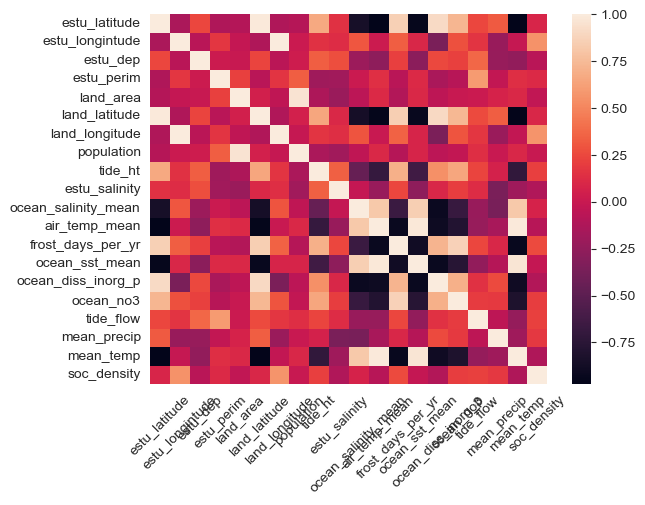

In [35]:
from utils import Linear_Reg_Diagnostic # do not change!
# using the same df as in question 1

df_salinity = df.loc[(df['ocean_salinity_mean']!=-9999),:]

# using correlations to decide which environmental factors to use to predict
# mean ocean salinity

correlations = df_salinity.corr()

sns.heatmap(correlations)
plt.xticks(rotation=45)
plt.savefig('OceanSalinityMeanCorrelations.png')
print(correlations)


To decide which environmental factors to use to predict the mean ocean salinity, I am looking at the correlations and choosing the variables with the strongest correlation with mean ocean salinity, whether it is positive or negative. Based on the table and heatmap, I found that the top variables that correlate the most with mean ocean salinity, from highest correlation down, include ocean_diss_inorg_p (-0.914380), land_latitude (-0.862551), estu_latitude (-0.852660), and ocean_sst_mean (0.849060). Consequently, these are the variables that I chose to create my linear model. 

## Question 3 

Using the `coal-production.csv` data, model the proportion of electricity produced with coal in high income countries over time with an ARIMA model. 

Process the data to be useable for time series analysis. (2 pt)

Display your data. Does it appear to have a trend? If so, describe the trend. (1 pt)

Test for stationarity. (1 pt)

Make an ARIMA model of the time series, either by manually testing different types, or with an auto-ARIMA. What type of ARIMA model was found to be the best fit? (2 pt)

Visualize the fitted values of the ARIMA model, being sure to label each line. (2 pt)

Make a forecast for 25 years after the conclusion of the time series and visualize with observed and fitted values. (2 pt)